**本代码来自伊莱·史蒂文斯著《PyTorch深度学习实战》**

In [1]:
import torch

version = torch.__version__  #查看PyTorch版本
print("torch_gpu version:", version)

torch_gpu version: 1.12.1


# 使用神经网络拟合数据

计算图是一种图形语言，图中每一个节点表示一个变量，变量可以是标量、向量、矩阵和张量等，操作（operation）是指一个或多个变量的简单函数。

## 人工神经元

$o=f(wx+b)$，其中x是输入（向量形式），w是权重或比例因子（矩阵形式），b是偏置或偏移量，f是激活函数。

### 选择最佳激活函数

激活函数特性：
- 激活函数是非线性的，非线性使得整个网络能够逼近更复杂的函数。
- 激活函数是可微的，因此可以通过他们计算梯度。

激活函数特征：
- 当输入到负无穷大时，接近一个下限。
- 正无穷时相似但上界相反。

## PyTorch nn模块

PyTorch有一个专门用于神经网络的子模块，叫做**torch.nn**，它包含创建各种神经网络结构所需的构建块（模块）。在其他框架中，这样的构建块通常称为层。  
PyTorch模块派生自基类nn.Module，一个模块可以有一个或多个参数实例作为属性，这些参数实例是张量，它们的值在训练过程中得到了优化。一个模块还可以有一个或多个子模块作为属性，并且它还能够跟踪它们的参数。  
nn.Module的一个子类称为nn.Linear，也就是其他框架中的**密集连接层**。

In [5]:
import torch.nn as nn
dir(nn)

['AdaptiveAvgPool1d',
 'AdaptiveAvgPool2d',
 'AdaptiveAvgPool3d',
 'AdaptiveLogSoftmaxWithLoss',
 'AdaptiveMaxPool1d',
 'AdaptiveMaxPool2d',
 'AdaptiveMaxPool3d',
 'AlphaDropout',
 'AvgPool1d',
 'AvgPool2d',
 'AvgPool3d',
 'BCELoss',
 'BCEWithLogitsLoss',
 'BatchNorm1d',
 'BatchNorm2d',
 'BatchNorm3d',
 'Bilinear',
 'CELU',
 'CTCLoss',
 'ChannelShuffle',
 'ConstantPad1d',
 'ConstantPad2d',
 'ConstantPad3d',
 'Container',
 'Conv1d',
 'Conv2d',
 'Conv3d',
 'ConvTranspose1d',
 'ConvTranspose2d',
 'ConvTranspose3d',
 'CosineEmbeddingLoss',
 'CosineSimilarity',
 'CrossEntropyLoss',
 'CrossMapLRN2d',
 'DataParallel',
 'Dropout',
 'Dropout1d',
 'Dropout2d',
 'Dropout3d',
 'ELU',
 'Embedding',
 'EmbeddingBag',
 'FeatureAlphaDropout',
 'Flatten',
 'Fold',
 'FractionalMaxPool2d',
 'FractionalMaxPool3d',
 'GELU',
 'GLU',
 'GRU',
 'GRUCell',
 'GaussianNLLLoss',
 'GroupNorm',
 'Hardshrink',
 'Hardsigmoid',
 'Hardswish',
 'Hardtanh',
 'HingeEmbeddingLoss',
 'HuberLoss',
 'Identity',
 'InstanceNorm1d

### 回到线性模型

In [6]:
import numpy as np
import torch.optim as optim

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1) 

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val
t_un_val

tensor([[8.1900],
        [6.8400]])

构造函数nn.Linear接收3个参数：输入特征的数量、输出特征的数量，以及线性模型是否包含偏置（默认为True）。

In [7]:
linear_model = nn.Linear(1, 1) #只有一个特征
linear_model(t_un_val)

tensor([[-1.3243],
        [-1.4841]], grad_fn=<AddmmBackward0>)

In [5]:
linear_model.weight #权重

Parameter containing:
tensor([[0.0134]], requires_grad=True)

In [6]:
linear_model.bias #偏置

Parameter containing:
tensor([0.6509], requires_grad=True)

#### 批量输入

nn中所有模块都可以被编写为同时为多个输入产生输出。

In [7]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.6643],
        [0.6643],
        [0.6643],
        [0.6643],
        [0.6643],
        [0.6643],
        [0.6643],
        [0.6643],
        [0.6643],
        [0.6643]], grad_fn=<AddmmBackward0>)

#### 优化批次

In [8]:
linear_model = nn.Linear(1, 1) 
optimizer = optim.SGD(
    linear_model.parameters(), 
    lr=1e-2)

In [9]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.4419]], requires_grad=True),
 Parameter containing:
 tensor([0.0283], requires_grad=True)]

In [10]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [11]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # 使用nn的损失函数，均方误差
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 379.0194, Validation loss 198.8020
Epoch 1000, Training loss 3.8736, Validation loss 4.2194
Epoch 2000, Training loss 3.1742, Validation loss 2.3584
Epoch 3000, Training loss 3.1538, Validation loss 2.1234

Parameter containing:
tensor([[5.2464]], requires_grad=True)
Parameter containing:
tensor([-16.6462], requires_grad=True)


## 最终完成一个神经网络

### 替换线性模型

nn提供了一种通过nn.Sequential容器来连接模型的方式：

In [12]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), 
            nn.Tanh(),
            nn.Linear(13, 1)) # 这里张量的输入必须和前面输出相同
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

### 检查参数

In [13]:
[param.shape for param in seq_model.parameters()] #收集线性模块的权重和偏置

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [14]:
for name, param in seq_model.named_parameters(): #输出每个模块的参数
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Sequential中的每个模块的名称就是模块在参数中出现的序号，可用OrderedDict命名每个模块。

In [15]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [16]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [17]:
seq_model.output_linear.bias #通过将子模块作为属性来访问一个特定的参数

Parameter containing:
tensor([0.3084], requires_grad=True)

In [18]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad) #输出梯度结果

Epoch 1, Training loss 188.6076, Validation loss 86.5259
Epoch 1000, Training loss 6.2313, Validation loss 1.3349
Epoch 2000, Training loss 5.1191, Validation loss 6.5692
Epoch 3000, Training loss 2.5574, Validation loss 6.3441
Epoch 4000, Training loss 1.7026, Validation loss 5.9506
Epoch 5000, Training loss 1.4559, Validation loss 6.1434
output tensor([[11.9857],
        [ 2.4233]], grad_fn=<AddmmBackward0>)
answer tensor([[14.0000],
        [ 0.5000]])
hidden tensor([[ 1.4411e+01],
        [-1.3667e+01],
        [-5.2854e-01],
        [-5.9334e-01],
        [ 1.5477e+01],
        [-1.4172e+01],
        [ 6.4552e-01],
        [ 1.2119e-03]])


### 与线性模型对比

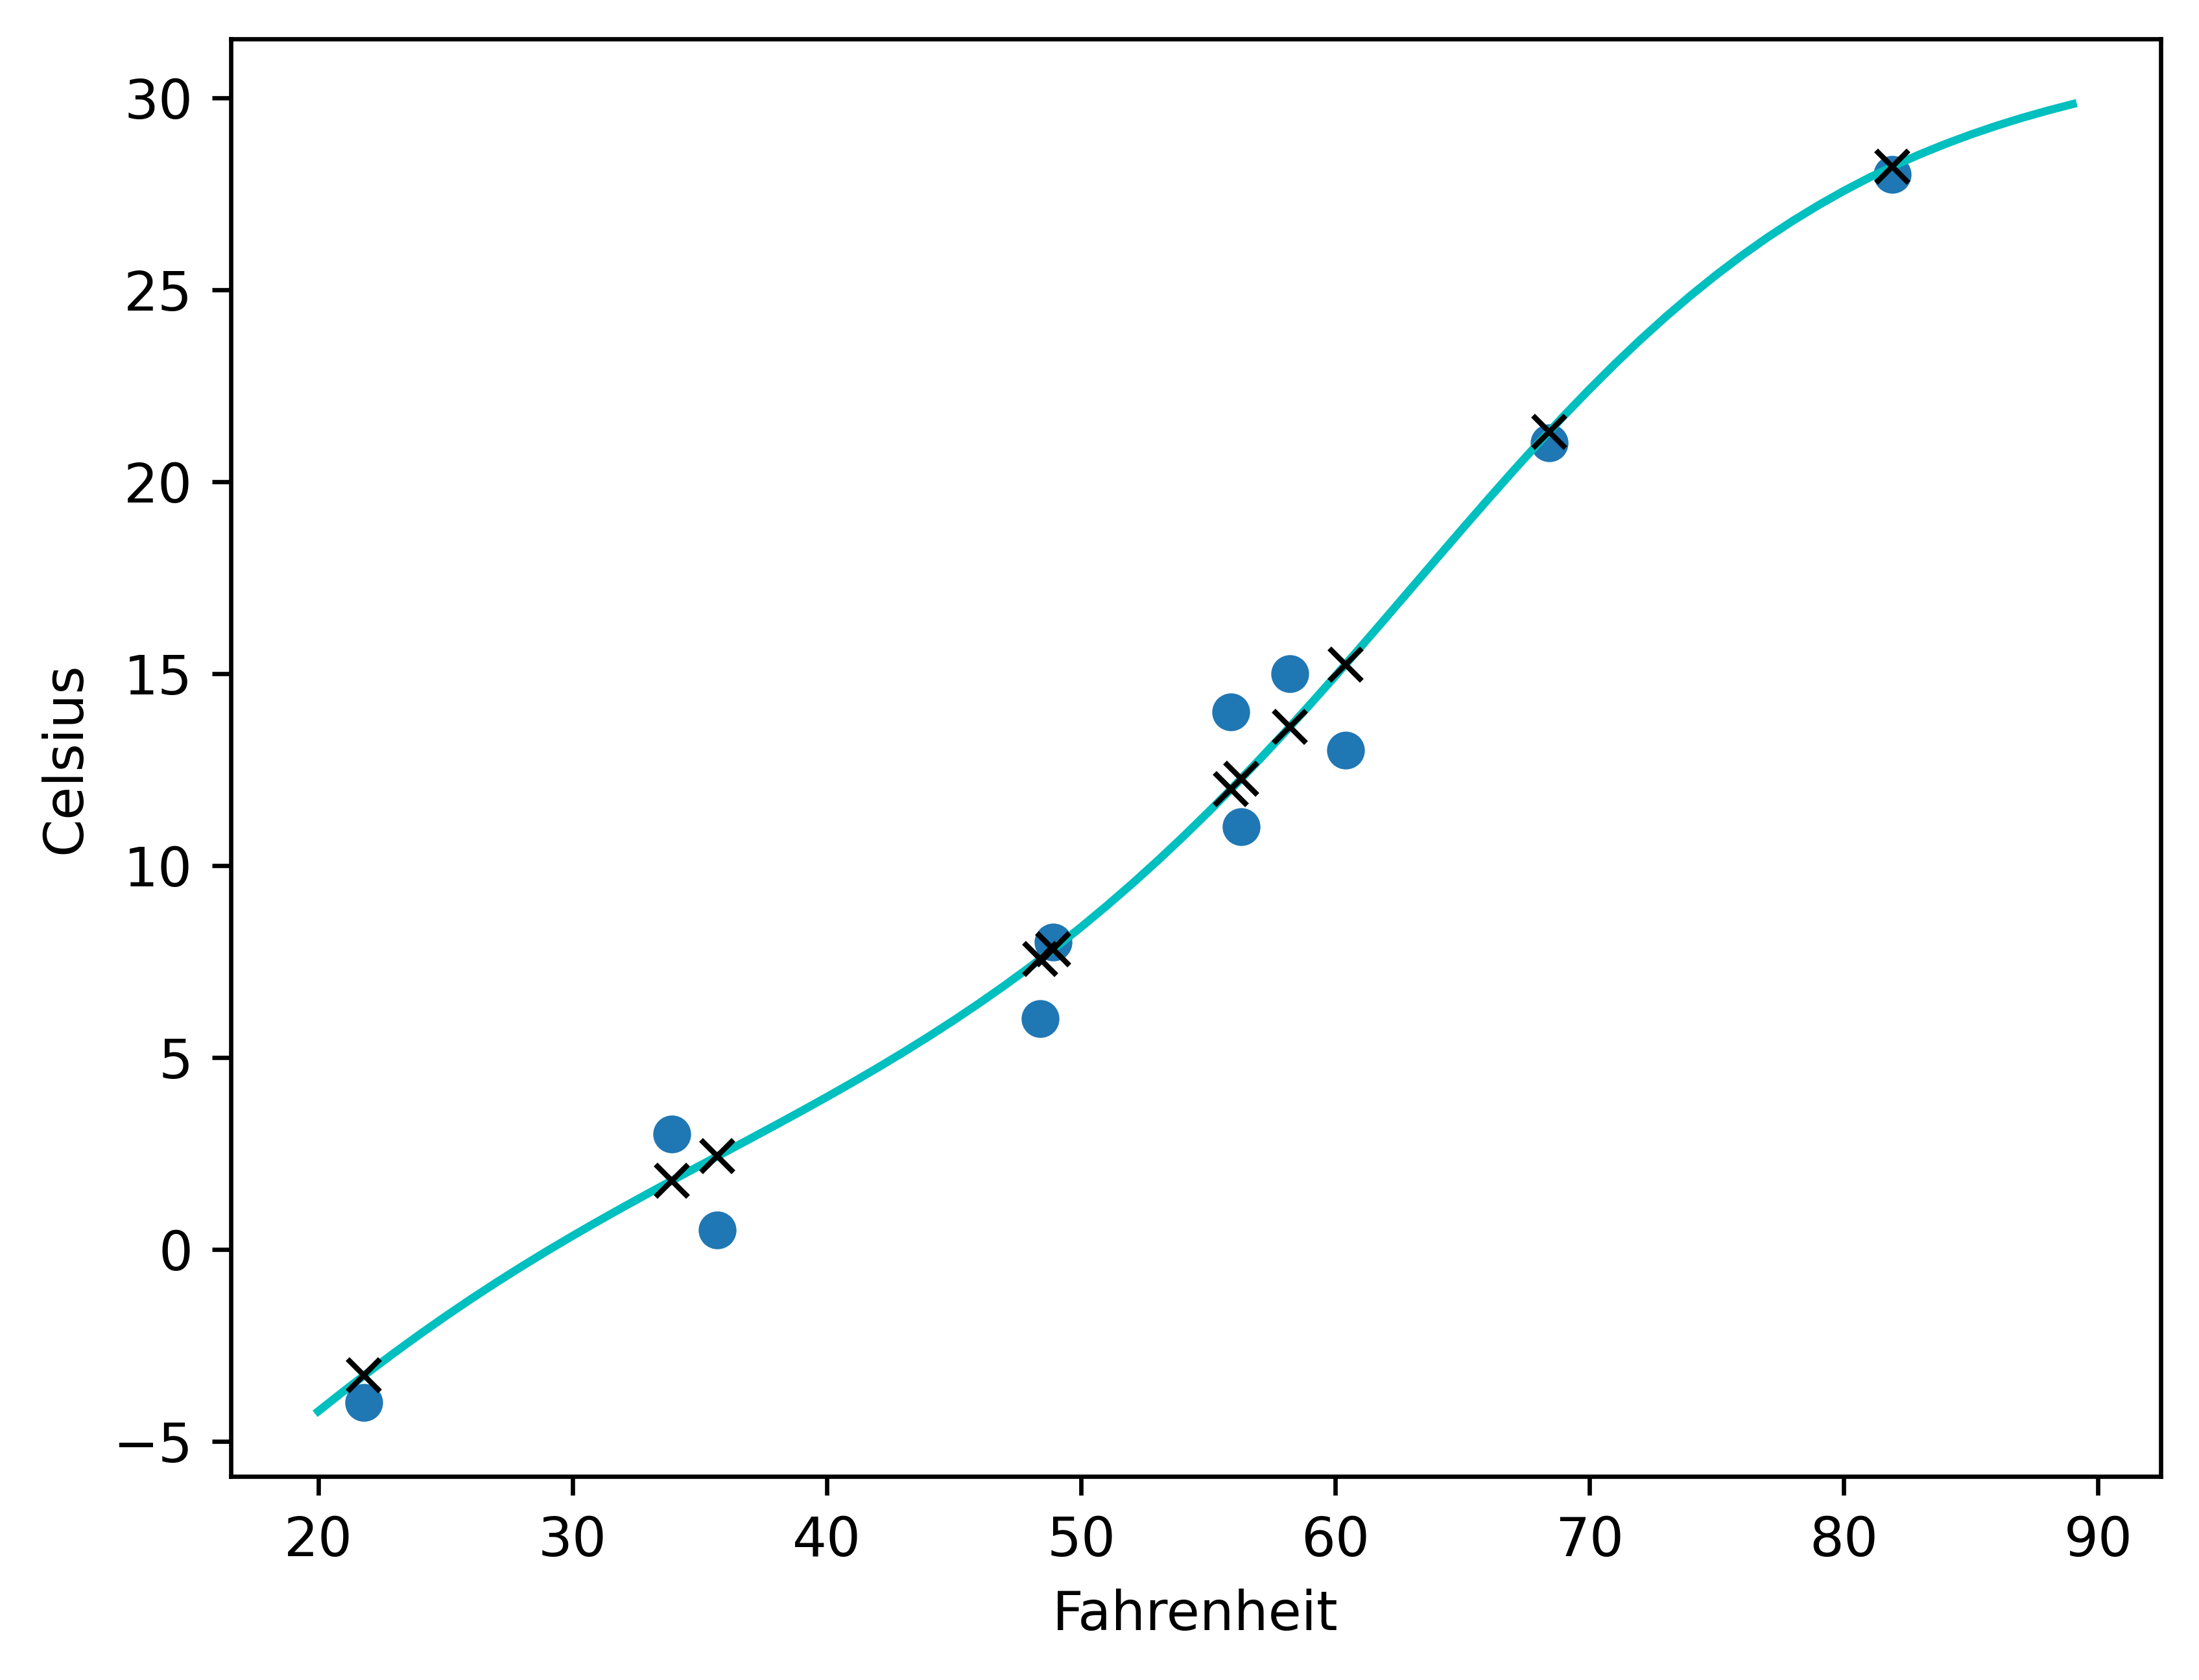

In [20]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

# 区分鸟和飞机：从图像学习

## 微小图像数据集

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

### 下载CIFAR-10

In [8]:
from torchvision import datasets
data_path = '../../../../data/python/data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # <1>
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) 

Files already downloaded and verified
Files already downloaded and verified


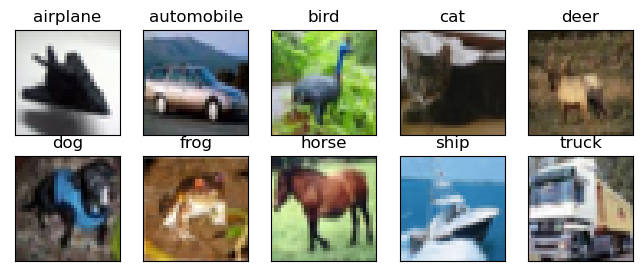

In [9]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

### Dataset类

In [10]:
len(cifar10)

50000

In [11]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

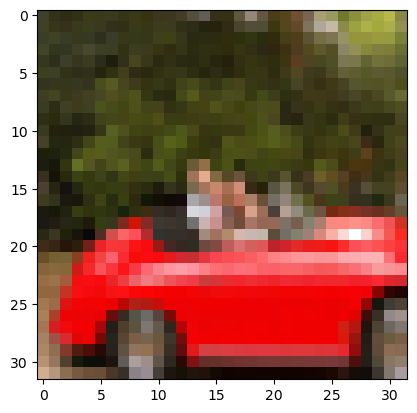

In [12]:
plt.imshow(img)
plt.show()

### Dataset变换

In [13]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [14]:
from torchvision import transforms
#ToTensor对象将Numpy数组和PIL图像变换为张量
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [15]:
#读取所有数据并转换为张量
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

In [16]:
img_t, _ = tensor_cifar10[99] #访问元素将返回一个张量，而不是PIL图像
type(img_t)

torch.Tensor

In [17]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [18]:
img_t.min(), img_t.max() #ToTensor变换将数据变换为每个通道的32位浮点数，值缩小为0.0～1.0

(tensor(0.), tensor(1.))

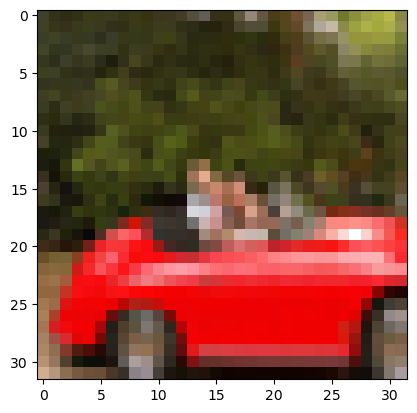

In [19]:
plt.imshow(img_t.permute(1, 2, 0))  # 改变轴的顺序，将C×H×W改写为H×W×C
plt.show()

### 数据归一化

In [20]:
#增加新的维度进行堆叠，这里将3维扩展为4维
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [21]:
imgs.view(3, -1).mean(dim=1)  #计算每个通道的平均值

tensor([0.4914, 0.4822, 0.4465])

In [22]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [23]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)) #初始化Normalize变换，mean和

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [24]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([ #连接函数
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
transformed_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../../../data/python/data-unversioned/p1ch7/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )

In [25]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


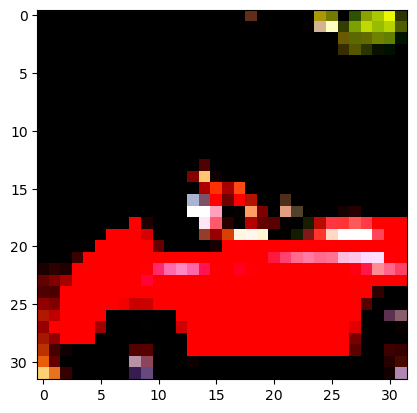

In [26]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## 区分鸟和飞机

### 构建数据集

In [27]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird'] #选取鸟和飞机的数据
cifar2 = [(to_tensor(img), label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(to_tensor(img), label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

### 一个全连接模型

图象只是一组在空间结构中排列的数字，理论上可以把图像像素拉成一个长的一维向量。**特征数=图像的高×图像的宽×通道数**

In [42]:
import torch.nn as nn

n_out = 2 #二分类
model = nn.Sequential(
            nn.Linear(
                3072,  # 隐藏层的大小，每个样本有32×32×3=3072个特征
                512,   
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # 隐藏层的大小
                n_out, 
            )
        )

### 分类器的输出

根据概率来处理问题需要对我们的网络输出施加一些额外的约束：
- 输出的每个元素必须在[0.0,1.0]的范围内。
- 输出的元素的总和必须为1.0。

### 用概率表示输出

In [43]:
#Softmax函数
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [44]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [45]:
softmax(x).sum()

tensor(1.)

nn模块将Softmax作为一个可用的模块，nn.Softmax()要求我们指定用来编码概率的维度。

In [46]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [47]:
#在原模型末尾加上nn.Softmax
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

In [48]:
imgb, _ = cifar2[0]

In [49]:
imgb

tensor([[[0.6431, 0.4118,  ..., 0.4235, 0.3569],
         [0.6549, 0.4549,  ..., 0.4118, 0.3490],
         ...,
         [0.6392, 0.6000,  ..., 0.3843, 0.4980],
         [0.7176, 0.6902,  ..., 0.3569, 0.4784]],

        [[0.8078, 0.5490,  ..., 0.5765, 0.5059],
         [0.8353, 0.6275,  ..., 0.5569, 0.4980],
         ...,
         [0.6157, 0.6431,  ..., 0.5804, 0.6980],
         [0.6000, 0.7137,  ..., 0.5216, 0.6667]],

        [[0.3294, 0.2392,  ..., 0.2706, 0.2235],
         [0.3294, 0.1922,  ..., 0.2824, 0.2235],
         ...,
         [0.3333, 0.3216,  ..., 0.1059, 0.1882],
         [0.4000, 0.4549,  ..., 0.1020, 0.1725]]])

### 分类的损失

nn.NLLLoss()被称为负对数似然损失函数，它显示了NLL作为预测概率的函数。

分类损失计算步骤：
- 运行正向传播，并从最后的线性层获得输出值。
- 计算它们的Softmax，并获得概率。
- 取与目标类别对应的预测概率。
- 计算它的对数，在它前面加上一个负号，再添加到损失中。

对于分类任务，在网络输出上使用Softmax函数产生的值满足被解释为概率的要求。在这种情况下，用Softmax的输出作为非负对数似然函数的输入，可得到理想的分类损失函数。在PyTorch中，将Softmax和这种损失的结合称为**交叉熵**。

### 训练分类器

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1)) #64行特征列
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.484748
Epoch: 1, Loss: 0.517571
Epoch: 2, Loss: 0.403559
Epoch: 3, Loss: 0.553917
Epoch: 4, Loss: 0.338231
Epoch: 5, Loss: 0.422949
Epoch: 6, Loss: 0.448860
Epoch: 7, Loss: 0.671955
Epoch: 8, Loss: 0.645381
Epoch: 9, Loss: 0.374774
Epoch: 10, Loss: 0.393359
Epoch: 11, Loss: 0.373423
Epoch: 12, Loss: 0.753814
Epoch: 13, Loss: 0.328563
Epoch: 14, Loss: 0.306385
Epoch: 15, Loss: 0.456247
Epoch: 16, Loss: 0.338652
Epoch: 17, Loss: 0.368026
Epoch: 18, Loss: 0.357644
Epoch: 19, Loss: 0.302873
Epoch: 20, Loss: 0.522269
Epoch: 21, Loss: 0.490049
Epoch: 22, Loss: 0.575505
Epoch: 23, Loss: 0.500384
Epoch: 24, Loss: 0.543135
Epoch: 25, Loss: 0.500569
Epoch: 26, Loss: 0.493788
Epoch: 27, Loss: 0.462509
Epoch: 28, Loss: 0.527103
Epoch: 29, Loss: 0.464794
Epoch: 30, Loss: 0.565496
Epoch: 31, Loss: 0.371412
Epoch: 32, Loss: 0.419809
Epoch: 33, Loss: 0.393703
Epoch: 34, Loss: 0.394548
Epoch: 35, Loss: 0.457351
Epoch: 36, Loss: 0.593710
Epoch: 37, Loss: 0.541429
Epoch: 38, Loss: 0.395

In [51]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.848500


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() #交叉熵损失函数

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.598484
Epoch: 1, Loss: 0.388315
Epoch: 2, Loss: 0.622152
Epoch: 3, Loss: 0.778148
Epoch: 4, Loss: 0.437636
Epoch: 5, Loss: 0.364789
Epoch: 6, Loss: 0.435244
Epoch: 7, Loss: 0.439877
Epoch: 8, Loss: 0.409726
Epoch: 9, Loss: 0.624501
Epoch: 10, Loss: 0.346708
Epoch: 11, Loss: 0.540288
Epoch: 12, Loss: 0.436759
Epoch: 13, Loss: 0.303287
Epoch: 14, Loss: 0.345228
Epoch: 15, Loss: 0.524195
Epoch: 16, Loss: 0.364837
Epoch: 17, Loss: 0.421539
Epoch: 18, Loss: 0.386156
Epoch: 19, Loss: 0.307443
Epoch: 20, Loss: 0.525961
Epoch: 21, Loss: 0.286393
Epoch: 22, Loss: 0.632678
Epoch: 23, Loss: 0.308045
Epoch: 24, Loss: 0.440701
Epoch: 25, Loss: 0.317506
Epoch: 26, Loss: 0.347066
Epoch: 27, Loss: 0.506961
Epoch: 28, Loss: 0.381714
Epoch: 29, Loss: 0.135010
Epoch: 30, Loss: 0.338770
Epoch: 31, Loss: 0.354530
Epoch: 32, Loss: 0.441514
Epoch: 33, Loss: 0.771696
Epoch: 34, Loss: 0.357345
Epoch: 35, Loss: 0.418567
Epoch: 36, Loss: 0.390595
Epoch: 37, Loss: 0.452829
Epoch: 38, Loss: 0.932

In [53]:
#训练集精度
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.844800


In [54]:
sum([p.numel() for p in model.parameters()]) #确定模型中参数的数量

3737474

# 使用卷积进行泛化

## 卷积介绍

卷积神经网络（convolutional neural network, CNN）是一种专门用来处理具有类似网格结构的数据的神经网络。 
- 卷积神经网络中一个典型层包含三级。在第一级中，这一层并行的计算多个卷积产生一组线性激活响应，即$w*x+b$（仿射变换）。在第二级中，每个线性激活响应将会通过一个非线性的激活函数（activate function）。在第三级中，使用池化函数（pooling function）来进一步调整这一层的输出。
- 卷积的运算通常用星号表示：$(x*w)(t)$。卷积的第一个参数通常叫做**输入**，即f；第二个参数叫做**核函数(卷积核)**,即w；输出有时被称为**特征映射**。
- 卷积的意义：输入和核函数的加权叠加（标量积）。
- 池化函数使用某一位置的相邻输出的总体特征来代替网络在该位置的输出（最大池化、平均池化等）。
- 当输入做出少量平移时，池化能够帮助输入的表示近似不变。**平移不变性**是指当我们对输入进行少量平移（卷积过程）时，经过池化函数后的大多数输出并不会发生变化。
- 经过卷积神经网络训练后，我们得到以下特征：1、邻域的局部操作（平移）；2、平移不变性；3、模型的参数大幅减少。

卷积神经网络的工作是估计连续层中的一组滤波器的卷积核，这些滤波器将把一个多通道图像转换成另一个多通道图像，其中不同的通道对应不同的特征，例如一个通道代表平均值，一个通道代表垂直边缘。

## 卷积实战

PyTorch中torch.nn模块提供一维、二维和三维的卷积，其中nn.Conv1d用于时间序列，nn.Conv2d用于图像，nn.Conv3d用于体数据和视频。

nn.Conv2d的参数至少包括输入特征（通道）的数量、输出特征的数量以及核的大小等。卷积核各个方向的大小都是相同的，因此指定kernel_size=3时，即表示卷积核的大小为3×3。

In [28]:
conv = nn.Conv2d(3, 16, kernel_size=3) 
conv 

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

### 填充边界

输出的宽度和高度可能与输入的宽度和高度不同，不同的原因可能是：
- 边界效应，一般情况下，当使用奇数卷积核时，输出比输入每个维度都少2个像素；使用偶数卷积核时，情况较为复杂，因此为了保证输出和输入维度相同，默认选择奇数卷积核。
- Pytorch提供了一种填充图像的可能性，通过在边界周围创建重影像素来填充图像，就卷积而言，这些重影像素的值为0.指定padding=1来填充。

In [29]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
conv

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [33]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape #输入维度和输出维度

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

### 用卷积检测特征

In [34]:
#初始化偏置和权重
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

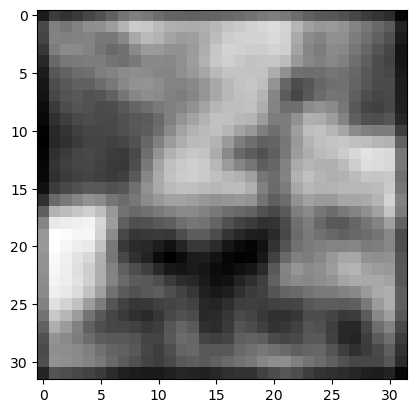

In [35]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show() #输入

In [36]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

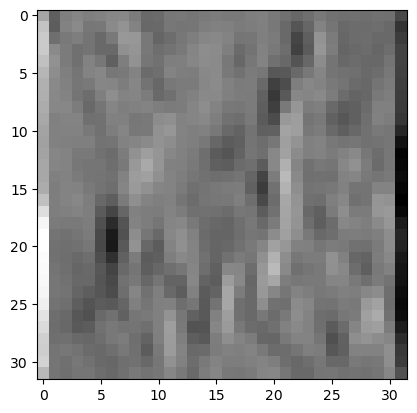

In [37]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show() #输出

### 使用深度和池化技术进一步研究

#### 从大到小：下采样

下采样如果将图像缩放一半相当于取4个相邻的像素作为输入，产生一个像素作为输出，可选择的操作：
- 取4个像素的平均值，现在已经不受欢迎。
- 取4个像素的最大值，这种方法称为最大池化（max pooling）。取不重叠的2×2个分片，并将每个分片上的最大值作为缩小后的新像素。
- 使用带有步长的卷积。

最大池化由nn.MaxPool2d模块提供，如果想把图像缩小一半，让核大小为2.

In [38]:
pool = nn.MaxPool2d(2)

In [39]:
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

#### 将卷积和下采样结合起来效果很好

### 为我们的网络整合一切

## 子类化nn.Module

当我们需要使用一些预设模块没有的东西，就需要放弃nn.Sequential运算带来的灵活性，PyTorch允许我们在模型中通过子类化nn.Module来进行任何运算。  
为了子类化nn.Module，我们至少需要定义一个forward()方法，该方法接收模块的输入并返回输出。  
通常情况下，运算将使用其他模块，为了包含这些子模块，我们通常在构造函数\__init__()中定义它们，并将它们赋给self以便在forward()方法中使用。

### 将我们的网络作为一个nn.Module

In [40]:
#编写子模块，Net相当于我们之前用子模块构建的nn.Sequential，但是是通过显式地编写forward()方法
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) #转换成样本数×特征数
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

### PyTorch如何跟踪参数和子模块

我们可以调用nn.Module子类的任意方法。子模块必须是顶级属性，对于子模块需要列表和字典的情况，PyTorch提供nn.ModuleList和nn.ModuleDict。

In [42]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### 函数式API

PyTorch对于每个nn模块都有对应的函数式API。这里的函数式指的是没有内部状态，换句话说，其输出值取决于输出参数的值。**torch.nn.functionl**提供了许多与nn中的模块类似的函数，他们将输入和参数作为函数调用的实参。

In [43]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.1130, -0.1188]], grad_fn=<AddmmBackward0>)

## 训练我们的convnet

卷积神经网络的核心是2个嵌套的循环：一个是跨迭代周期的外部循环，另一个是从数据集生成批次的DataLoader的内部循环。在每个循环中，我们必须这么做：
- 通过模型提供输入（正向传播）
- 计算损失（正向传播）
- 将先前的梯度都归零
- 调用loss.backward()来计算损失相对于所有参数的梯度（反向传播）
- 让优化器朝着更低的损失迈进

In [45]:
import datetime  # 计算时间

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # 训练周期
        loss_train = 0.0
        for imgs, labels in train_loader:  # 批次循环
            outputs = model(imgs)  # 提供一个批次给模型
            loss = loss_fn(outputs, labels)  # 计算损失
            optimizer.zero_grad()  # 梯度归零
            loss.backward()  # 计算所有参数的梯度
            optimizer.step()  # 更新模型
            loss_train += loss.item()  # 损失求和

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # 每批平均损失

In [47]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # 数据加载器

model = Net()  #  nn.Module的一个子类
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  随机梯度下降优化器
loss_fn = nn.CrossEntropyLoss()  #  交叉熵损失

training_loop(  
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-10-02 20:07:22.081871 Epoch 1, Training loss 0.6809491701186843
2022-10-02 20:07:46.579690 Epoch 10, Training loss 0.4658014174479588
2022-10-02 20:08:14.408371 Epoch 20, Training loss 0.3575739462853997
2022-10-02 20:08:42.368193 Epoch 30, Training loss 0.3246490302359223
2022-10-02 20:09:12.099251 Epoch 40, Training loss 0.3065696262819752
2022-10-02 20:09:41.370315 Epoch 50, Training loss 0.2927452211926697
2022-10-02 20:10:11.553489 Epoch 60, Training loss 0.27818662250877185
2022-10-02 20:10:40.171247 Epoch 70, Training loss 0.2647699763061135
2022-10-02 20:11:09.594019 Epoch 80, Training loss 0.2523608844561182
2022-10-02 20:11:38.686304 Epoch 90, Training loss 0.23948049671046293
2022-10-02 20:12:09.237389 Epoch 100, Training loss 0.23121479229562603


### 测量准确率

In [48]:
#模型在训练集和验证集上的准确率
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # 验证时不需要计算梯度
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 将最大值的索引作为输出
                total += labels.shape[0]  # 计算样本数
                correct += int((predicted == labels).sum())  # 预测正确的数量

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.88


### 保存并加载我们的模型

In [56]:
data_path = '../../../../data/python/model/'
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

现在birds_vs_airplanes.pt文件中包含模型的所有参数：即2个卷积模块和2个线性模块的权重和偏置。因此，模型没有结构，只有权重。

In [57]:
loaded_model = Net()  # 必须确保模型不被更改
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### 在GPU上训练

nn.Module模块实现了一个将模型所有参数移动到GPU上的to()方法。Module.to和Tensor.to之间有一个微小的区别，区别在于模块实例是否被修改。对Module.to来说，模块的实例会被修改。

In [58]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [67]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # 将数据移动到GPU上训练
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [60]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # 将模型参数移动到GPU上
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-10-02 20:34:43.769426 Epoch 1, Training loss 0.6627039131085584
2022-10-02 20:34:50.342993 Epoch 10, Training loss 0.45064703503232095
2022-10-02 20:34:57.641354 Epoch 20, Training loss 0.35066812082081084
2022-10-02 20:35:04.371077 Epoch 30, Training loss 0.3242404633646558
2022-10-02 20:35:11.169779 Epoch 40, Training loss 0.30881908450536666
2022-10-02 20:35:17.983721 Epoch 50, Training loss 0.290503051630251
2022-10-02 20:35:24.704453 Epoch 60, Training loss 0.2788712053921572
2022-10-02 20:35:31.398856 Epoch 70, Training loss 0.26404957240744004
2022-10-02 20:35:38.397831 Epoch 80, Training loss 0.2525677325049783
2022-10-02 20:35:45.466289 Epoch 90, Training loss 0.2397333392576807
2022-10-02 20:35:52.479565 Epoch 100, Training loss 0.22997629808582318


In [64]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device) # 将数据移动到GPU上训练
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

validate(model, train_loader, val_loader)

Accuracy train: 0.91
Accuracy val: 0.88


{'train': 0.9057, 'val': 0.8795}

In [65]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device)) #加载权重时，PyTroch覆盖设备信息

<All keys matched successfully>

## 模型设计

### 增加内存容量：宽度

这里的宽度指的是模型输出的通道数。

In [7]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32): #提前设置好输出通道数（过滤器个数）
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### 帮助我们的模型收敛和泛化：正则化

#### 检查参数：权重惩罚

稳定泛化的第1种方法是在损失中添加一个正则化项。减小模型本身的权重，使损失更平滑。比较流行的是L2正则化，也称为权重衰减。

In [68]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # 对L1正则化则使用abs()替换pow(2.0)
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

#### 不太依赖于单一输入：Dropout

在PyTorch中，可以通过在非线性激活与后面的线性或卷积模块之间添加一个nn.Dropout模块在模型中实现Dropout作为一个参数，需要指定输入归零的概率。如果是卷积，可使用专门的nn.Dropout2d或者nn.Dropout3d，将输入的所有通道归零。

In [69]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

#### 保持激活检查：批量归一化

批量归一化主要思想是将输入重新调整到网络的激活状态，从而使小批量具有一定的理想分布。PyTorch提供了nn.BatchNorm1d、nn.BatchNorm2d和nn.BatchNorm3d来实现批量归一化。位置是变换和激活函数之后。

In [70]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1) #批量归一化
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2) #批量归一化
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### 深度学习更复杂的结构：深度

#### 跳跃连接

在残差网络中，提出了一种技巧来训练训练深度学习模型，名为跳跃连接。该方法使得神经网络层数从15年无法到达20层提高到上百层。  
跳跃连接将输入添加到层块的一个输出中，可有效防止梯度消失和梯度爆炸。比如将第1个激活函数的输出作为最后一个激活函数的输入。

In [71]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) #跳跃连接
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

#### 使用PyTorch建立非常深的网络

In [72]:
#首先创建一个模块子类，它的唯一任务是为一个块提供计算，该块包含一组卷积、激活函数和跳跃连接
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [73]:
#接着在__init__()中创建nn.Sequential，最后在forward()中，调用nn.Sequential来遍历100个块并生成输出
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

#### 初始化

初始化是训练神经网络的一个重要技巧，但PyTorch的默认权重初始化并不理想。

## 本章小结

卷积可以作为处理图像的前馈网络的线性运算，利用其局部性和平移不变性，使用卷积产生的网络参数更少。

将多个卷积及其激活逐个叠加，并在两者之间使用最大池化，可以将卷积应用于越来越小的特征图像，从而有效地解释随着深度的增加，输入图像中更大部分的空间关系。

# 部署到生产环境

PyTorch生态中，使用JIT编译器，这是一种即时的编译器，用于以PyTorch为中心的Python子集。